# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:38<00:00, 2296.88it/s]


In [20]:
preprocessed_reviews[150]

'dog toy huge hit house added bulldog puppy family awake teeth constantly seeking something sink toy hard enough hold not hard loses interest irregular shapes great giving multiple chew spots toy dinosaur even brought puppy old mix never big chew toys ca not go wrong one'

# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [30]:

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [172]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [173]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8588066101074219), ('awesome', 0.8353956341743469), ('excellent', 0.8164411783218384), ('terrific', 0.8028125762939453), ('good', 0.7966592311859131), ('wonderful', 0.7864940166473389), ('perfect', 0.7783714532852173), ('amazing', 0.7605545520782471), ('fabulous', 0.7278140187263489), ('nice', 0.6960620880126953)]
[('greatest', 0.8084233999252319), ('best', 0.7302747964859009), ('tastiest', 0.716764509677887), ('nastiest', 0.6753560304641724), ('smoothest', 0.6704479455947876), ('coolest', 0.6595950126647949), ('nicest', 0.6314501762390137), ('disgusting', 0.6031796336174011), ('horrible', 0.592613160610199), ('overrated', 0.5817391872406006)]


In [43]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [11:23<00:00, 128.45it/s]


87773
50


# [5]Applying SVM

## [5.1] Linear SVM

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV


In [22]:
x1, x_test, y1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size = 0.2)
x_train,x_cv , y_train,y_cv = train_test_split(x1,y1,test_size = 0.2)

In [23]:
def LinearSVM(x_tr,x_cv,x_tst):
    alphas = np.array([1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4])
    penalties = ('l1','l2')
    pred_cv = []
    pred_train = []
    
    #finding the best hyperparameter
    for alpha in alphas:
        for p in penalties:
            m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha, n_jobs=-1)
            model = CalibratedClassifierCV(base_estimator=m, cv = 3)
            model.fit(x_tr,y_train)
            prob = model.predict_proba(x_cv)
            prob_tr = model.predict_proba(x_tr)
            train_roc = roc_auc_score(y_train, prob_tr[:,1])#taking probability of positive class only
            cv_roc = roc_auc_score(y_cv,prob[:,1])
            pred_cv.append(cv_roc)
            pred_train.append(train_roc)
            print("CV score is %f and Training score is %f for alpha %f and penalty %s"%(cv_roc,train_roc,alpha,p))
    
    #printing optimal values
    optimal_alpha = alphas[int(pred_cv.index(max(pred_cv))/2)]
    print("optimal alpha is" ,optimal_alpha)
    if pred_cv.index(max(pred_cv))%2 == 1:
        penalty = 'l2'
    else:
        penalty = 'l1'
    print("optimal_penalty is", penalty)
    
    #plotting cv and train roc values for each value of alpha
    sns.set_style('whitegrid')
    plt.plot(np.log10(alphas),pred_cv[::2],'r-',linewidth = 5,label = 'ROC AUC for CV data')
    plt.plot(np.log10(alphas),pred_train[::2],'g-',linewidth = 3,label = "ROC AUC for train data")
    plt.title('train and cv roc values with alpha')
    plt.xlabel('log10(alphas)')
    plt.ylabel('roc auc value')
    plt.legend()
    plt.show()  

    
    #final Classifier with optimal values
    clf = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty = penalty, n_jobs=-1)
    model = CalibratedClassifierCV(base_estimator=clf, cv=3)
    model.fit(x_tr,y_train)
    prob_test = model.predict_proba(x_tst)
    prob_train = model.predict_proba(x_tr)
    test_roc = roc_auc_score(y_test,prob_test[:,1])
    train_roc = roc_auc_score(y_train,prob_train[:,1])
    fpr1,tpr1,thresholds1 = roc_curve(y_test,prob_test[:,1])
    fpr,tpr,thresholds = roc_curve(y_train,prob_train[:,1])
    
    #roc curve plots for train and test data
    plt.plot([0,1], [0,1], 'b--')
    plt.plot(fpr1,tpr1,label = 'Test ROC ' + str(test_roc))
    plt.plot(fpr,tpr, label = 'Training ROC '+str(train_roc))
    plt.title('ROC Curves for train and test data')
    plt.legend()
    plt.show()
    print('ROC AUC value on test data  is', test_roc)
    
    
    #plotting confusion matrix
    sns.set_style('white')
    y_pred = model.predict(x_tst)
    plot_confusion_matrix(y_test,y_pred, figsize=(5,5))
    plt.show()
    

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

CV score is 0.941995 and Training score is 0.970197 for alpha 0.000100 and penalty l1
CV score is 0.955032 and Training score is 0.998179 for alpha 0.000100 and penalty l2
CV score is 0.900556 and Training score is 0.912348 for alpha 0.001000 and penalty l1
CV score is 0.955439 and Training score is 0.983795 for alpha 0.001000 and penalty l2
CV score is 0.725645 and Training score is 0.732713 for alpha 0.010000 and penalty l1
CV score is 0.937852 and Training score is 0.952877 for alpha 0.010000 and penalty l2
CV score is 0.517608 and Training score is 0.514496 for alpha 0.100000 and penalty l1
CV score is 0.797907 and Training score is 0.798791 for alpha 0.100000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 1.000000 and penalty l1
CV score is 0.529790 and Training score is 0.525628 for alpha 1.000000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 10.000000 and penalty l1
CV score is 0.558443 and Training score is 0.564589 f

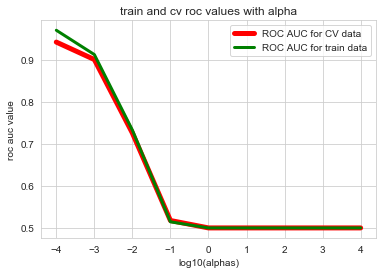

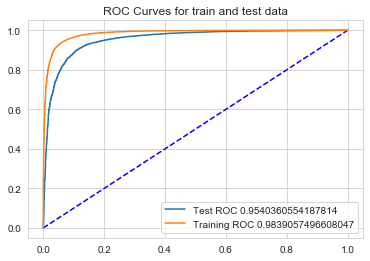

ROC AUC value on test data  is 0.9540360554187814


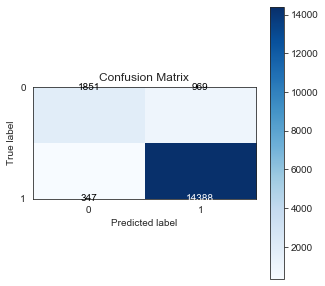

In [24]:
#bow vectorization with unigrams and bigrams
count_vect = CountVectorizer(ngram_range = (1,2), min_df = 10)

train_bow = count_vect.fit_transform(x_train)
cv_bow  = count_vect.transform(x_cv)
test_bow = count_vect.transform(x_test)

LinearSVM(train_bow,cv_bow,test_bow)


In [26]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.01, penalty = 'l2', n_jobs=-1)
clf.fit(train_bow,y_train)


SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
#printing top 10 positive features

features = count_vect.get_feature_names()
w = clf.coef_
#creating dictionary of feature names and respective weights
feature_dict = dict(zip(w[0], features))
w_ = sorted(w[0].data, reverse = True)
print('Top 10 features of positive class are:')
for i in range(0,10):
    print(feature_dict[w_[i]])


Top 10 features of positive class are:
great
delicious
best
loves
perfect
excellent
wonderful
nice
not disappointed
love


In [28]:
#printing top 10 negative features
print("top 10 negative features are:")
for i in range(-1,-11,-1):
    print(feature_dict[w_[i]])
      

top 10 negative features are:
disappointed
awful
worst
not buy
horrible
not worth
money
not good
terrible
return


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [29]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 10)


train_tfidf = tfidf_vect.fit_transform(x_train)
cv_tfidf = tfidf_vect.transform(x_cv)
test_tfidf = tfidf_vect.transform(x_test)

CV score is 0.936446 and Training score is 0.942907 for alpha 0.000100 and penalty l1
CV score is 0.959023 and Training score is 0.976629 for alpha 0.000100 and penalty l2
CV score is 0.726345 and Training score is 0.735235 for alpha 0.001000 and penalty l1
CV score is 0.951469 and Training score is 0.965846 for alpha 0.001000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 0.010000 and penalty l1
CV score is 0.951752 and Training score is 0.966069 for alpha 0.010000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 0.100000 and penalty l1
CV score is 0.604653 and Training score is 0.602535 for alpha 0.100000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 1.000000 and penalty l1
CV score is 0.601851 and Training score is 0.599590 for alpha 1.000000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 10.000000 and penalty l1
CV score is 0.601851 and Training score is 0.599590 f

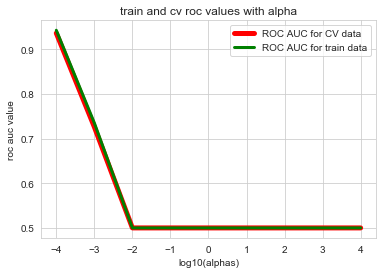

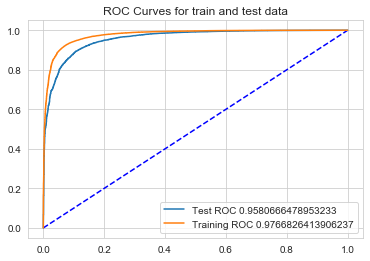

ROC AUC value on test data  is 0.9580666478953233


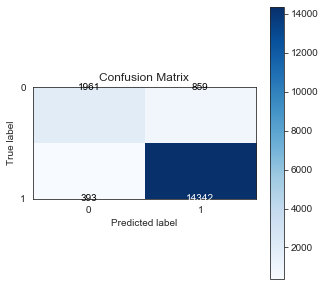

In [30]:
std = Normalizer()
train_tfidf_nr = std.fit_transform(train_tfidf)
cv_tfidf_nr = std.transform(cv_tfidf)
test_tfidf_nr = std.transform(test_tfidf)

LinearSVM(train_tfidf_nr,cv_tfidf_nr,test_tfidf_nr)

In [31]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.0001, penalty = 'l2', n_jobs=-1)
clf.fit(train_tfidf,y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
#printing top 10 positive features

features = tfidf_vect.get_feature_names()
w = clf.coef_
#creating dictionary of feature names and respective weights
feature_dict = dict(zip(w[0], features))
w_ = sorted(w[0].data, reverse = True)
print('Top 10 features of positive class are:')
for i in range(0,10):
    print(feature_dict[w_[i]])

Top 10 features of positive class are:
great
best
good
not disappointed
delicious
nice
perfect
loves
amazing
excellent


In [33]:
#printing top 10 negative features
print("top 10 negative features are:")
for i in range(-1,-11,-1):
    print(feature_dict[w_[i]])
      

top 10 negative features are:
disappointed
worst
not worth
awful
horrible
not buy
terrible
not
disappointing
return


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [34]:
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
        
w2v=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2vwords = list(w2v.wv.vocab)

In [35]:
w2v.most_similar('great')



[('fantastic', 0.8182251453399658),
 ('excellent', 0.8173952698707581),
 ('good', 0.8055962324142456),
 ('awesome', 0.8016706705093384),
 ('terrific', 0.7949281930923462),
 ('wonderful', 0.7519721388816833),
 ('perfect', 0.7437779903411865),
 ('amazing', 0.7156490683555603),
 ('fabulous', 0.6779736280441284),
 ('nice', 0.6554453372955322)]

In [38]:

def avgw2v(sentances):
    list_of_sentance=[]
    for sentance in sentances:
        list_of_sentance.append(sentance.split())
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2vwords:
                vec = w2v.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    

In [39]:
train_w2v = avgw2v(x_train)
cv_w2v = avgw2v(x_cv)
test_w2v = avgw2v(x_test)


100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:46<00:00, 374.13it/s]


CV score is 0.897118 and Training score is 0.899618 for alpha 0.000100 and penalty l1
CV score is 0.897291 and Training score is 0.899199 for alpha 0.000100 and penalty l2
CV score is 0.900247 and Training score is 0.902252 for alpha 0.001000 and penalty l1
CV score is 0.900778 and Training score is 0.902818 for alpha 0.001000 and penalty l2
CV score is 0.893375 and Training score is 0.894070 for alpha 0.010000 and penalty l1
CV score is 0.900527 and Training score is 0.902234 for alpha 0.010000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 0.100000 and penalty l1
CV score is 0.897321 and Training score is 0.898499 for alpha 0.100000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 1.000000 and penalty l1
CV score is 0.893861 and Training score is 0.894469 for alpha 1.000000 and penalty l2
CV score is 0.500000 and Training score is 0.500000 for alpha 10.000000 and penalty l1
CV score is 0.746206 and Training score is 0.745555 f

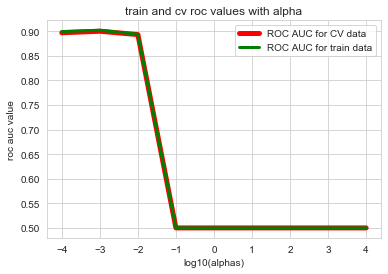

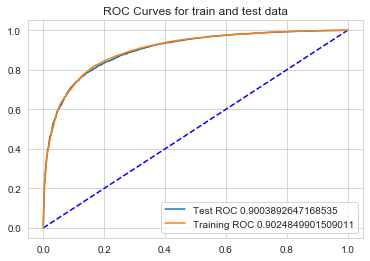

ROC AUC value on test data  is 0.9003892647168535


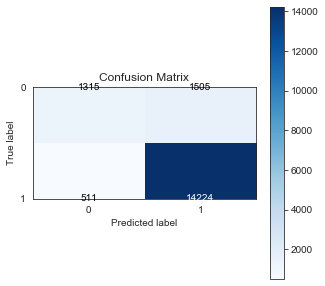

In [40]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler(with_mean = False)
train_w2v = std.fit_transform(train_w2v)
test_w2v = std.transform(test_w2v)
cv_w2v  = std.transform(cv_w2v)

LinearSVM(train_w2v,cv_w2v,test_w2v)

## [5.2] RBF SVM

In [41]:
def RBF_SVM(x_tr,x_tst):
    C = np.array([1e-3,1e-2,1e-1,1,1e1,1e2])
    gamma = np.array([1e-4,1e-3,1e-2,1e-1,1,1e1])
    params = {'C':C,'gamma':gamma}
    
    #finding the best hyperparameter
    model = GridSearchCV(SVC(kernel = 'rbf'),params,n_jobs=-1,cv = 3, scoring = 'roc_auc')
    model.fit(x_tr[0:500],y_train1[0:500])
    print(model.best_estimator_)
    param = model.best_params_
    optimal_C = param['C']
    optimal_gamma = param['gamma']
    
    #fitting the best model
    model = SVC(kernel = 'rbf', probability=True,C=optimal_C,gamma=optimal_gamma)
    model.fit(x_tr,y_train1)
    

    
    #final Classifier with optimal values
    prob_test = model.predict_proba(x_tst)
    prob_train = model.predict_proba(x_tr)
    test_roc = roc_auc_score(y_test1,prob_test[:,1])
    train_roc = roc_auc_score(y_train1,prob_train[:,1])
    fpr1,tpr1,thresholds1 = roc_curve(y_test1,prob_test[:,1])
    fpr,tpr,thresholds = roc_curve(y_train1,prob_train[:,1])
    
    #roc curve plots for train and test data
    plt.plot([0,1], [0,1], 'b--')
    plt.plot(fpr1,tpr1,label = 'Test ROC ' + str(test_roc))
    plt.plot(fpr,tpr, label = 'Training ROC '+str(train_roc))
    plt.title('ROC Curves for train and test data')
    plt.legend()
    plt.show()
    print('ROC AUC value on test data  is', test_roc)
    
    
    #plotting confusion matrix
    sns.set_style('white')
    y_pred = model.predict(x_tst)
    plot_confusion_matrix(y_test1,y_pred, figsize=(5,5))
    plt.show()
    

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [42]:
count_vect = CountVectorizer(ngram_range = (1,2), min_df = 10 ,max_features = 500)
train_bow = count_vect.fit_transform(x_train)
test_bow = count_vect.transform(x_test)



In [44]:

train_bow = train_bow[0:25000]
print(train_bow.shape)
test_bow = test_bow[0:10000]
print(test_bow.shape)
y_train1 = y_train[0:25000]
y_test1 = y_test[0:10000]


train_bow_std = std.fit_transform(train_bow)
test_bow_std = std.transform(test_bow)

(25000, 500)
(10000, 500)


SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


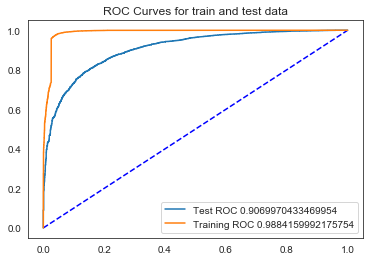

ROC AUC value on test data  is 0.9069970433469954


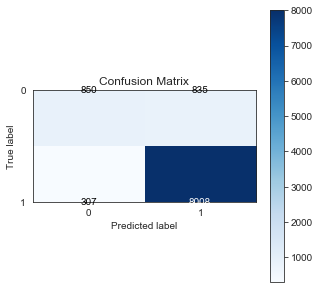

In [246]:
RBF_SVM(train_bow_std,test_bow_std)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


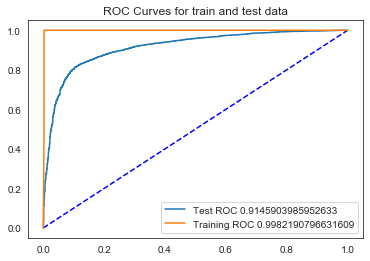

ROC AUC value on test data  is 0.9145903985952633


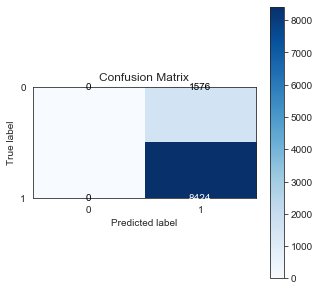

In [45]:
train_tfidf_std = std.fit_transform(train_tfidf)
test_tfidf_std = std.transform(test_tfidf)

train_tfidf_std = train_tfidf_std[0:25000]
test_tfidf_std = test_tfidf_std[0:10000]

RBF_SVM(train_tfidf_std, test_tfidf_std)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


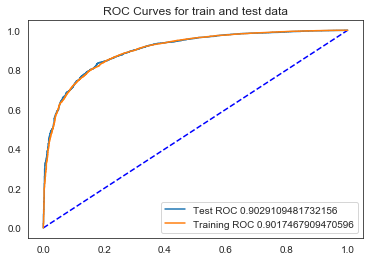

ROC AUC value on test data  is 0.9029109481732156


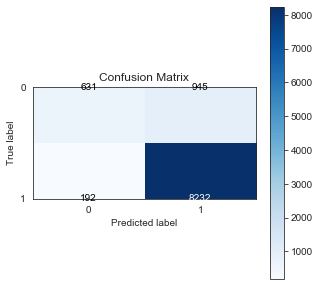

In [46]:
train_w2v1 = train_w2v[0:25000]
test_w2v1 = test_w2v[0:10000]

RBF_SVM(train_w2v1, test_w2v1)

# [6] Conclusions

In [50]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyperparameters","Test auc score"]
table.add_row(["Bag of words", "LinearSVM", "alpha =  0.001, penalty = l2", 0.9540360554187814])
table.add_row(["TF_IDF", "LinearSVM", "alpha =  0.0001, penalty = l2", 0.9580666478953233])
table.add_row(["Average Word2Vec", "LinearSVM", "alpha =  0.001, penalty = l2", 0.9003892647168535])
table.add_row(["Bag of words", "RBF kernel SVM", "C = 10, gamma = 0.001", 0.9069970433469954])
table.add_row(["TF_IDF", "RBF kernel SVM", "C = 0.01, gamma = 0.0001", 0.9145903985952633])
table.add_row(["Average Word2Vec", "RBF kernel SVM", "C = 10, gamma = 0.0001", 0.9029109481732156])

print(table)

+------------------+----------------+-------------------------------+--------------------+
|    Vectorizer    |     Model      |        Hyperparameters        |   Test auc score   |
+------------------+----------------+-------------------------------+--------------------+
|   Bag of words   |   LinearSVM    |  alpha =  0.001, penalty = l2 | 0.9540360554187814 |
|      TF_IDF      |   LinearSVM    | alpha =  0.0001, penalty = l2 | 0.9580666478953233 |
| Average Word2Vec |   LinearSVM    |  alpha =  0.001, penalty = l2 | 0.9003892647168535 |
|   Bag of words   | RBF kernel SVM |     C = 10, gamma = 0.001     | 0.9069970433469954 |
|      TF_IDF      | RBF kernel SVM |    C = 0.01, gamma = 0.0001   | 0.9145903985952633 |
| Average Word2Vec | RBF kernel SVM |     C = 10, gamma = 0.0001    | 0.9029109481732156 |
+------------------+----------------+-------------------------------+--------------------+
